# Stress-strain curves for a standard linear solid 

In this notebook, we utilize the standard linear solid model (SLS) of `deformation_models` to calculate strain evolution from an arbitrary applied stress.

First, let's import all the packages and libraries that we'll need:

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf

from deformation_models import SLS

Let's start by defining an applied stress from which we will calculate cumulative strain. We'll define it as a time-dependent function to make integration easier later on. And we'll use some error-function tricks to have a rapid increase to a constant stress followed by a decrease to another constant stress:

In [2]:
stress_ramp_time = 0.5
t_stress = 20
t_stress_off = 80
stress_amp = 1e8
dt_max = stress_ramp_time / 10


def stress(t):
    stress_on = erf((t - t_stress) / stress_ramp_time)
    stress_off = 0.5 * erf((t - t_stress_off) / stress_ramp_time)
    return stress_amp * 0.5 * (1 + stress_on - stress_off)

let's check out what it looks like:

Text(0, 0.5, 'stress [Pa]')

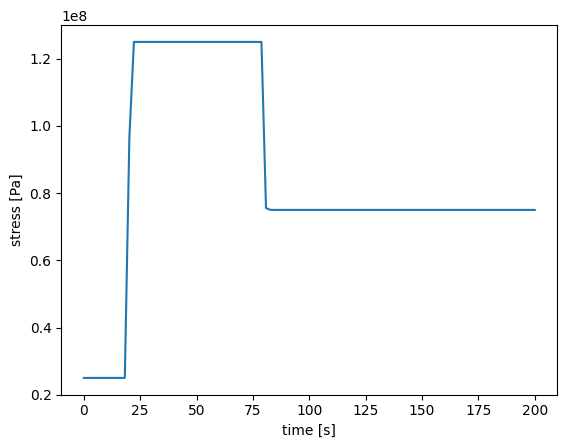

In [3]:
t = np.linspace(0, 200, 100)
stress_t = stress(t)
plt.plot(t, stress_t)
plt.xlabel("time [s]")
plt.ylabel("stress [Pa]")

Now let's define our solid model:

In [4]:
Ju_1 = 1 / (60 * 1e9)
Ju_2 = 1 / (70 * 1e9)
tau_m = 1e12 * Ju_2
sls_solid = SLS(Ju_1, tau_m, Ju_2)

Finally, we need some methods to actually calculate strain. 

In linear materials, you can treat the strain as an incremental response to applied stress, accounting for all of the past stress steps. This means for a specific time `t1`, you have to sum up the product of the creep function and applied stress at all prior stress states: essentially a convolution between strain and creep function. 

So let's define 3 functions:

1. `stress_steps`. given an array of time values and a function for calculating the stress, calculate the step in stress at every time value:

In [5]:
def stress_steps(tstar, stress_func):
    stress_dot_t = stress_func(tstar)
    return stress_dot_t[1:] - stress_dot_t[:-1]

2. `J_signal`. for a given solid model, actual time and prior time (`tstar`), calculate the creep function response for that time difference:

In [6]:
def J_signal(solid, t, tstar):
    t_diff = t - tstar
    return solid.J_t(t_diff)[0:-1]

3. `calc_stress_srain`: finally, a function to actually run the calculation. 

In [7]:
def calc_stress_strain(tmax, dt_max, stress_func, solid, tmin=0.001, n_t=1000):
    """
    calculate strain evolution for an applied-stress stress function

    Parameters
    ----------
    tmax: the max time to calculate for
    dt_max: the max allowed timestep when convolving stress with creep function
    stress_func: the function to use for calculating stress at a given time
    solid: the deformation_model solid instance to calculate strain for
    tmin: the starting time (default 0.001)
    n_t: number of timesteps

    Returns
    -------
    tuple
        a 3-element tuple of np arrays: (strain_vals, stress_vals, t_actual)
        strain_vals: the accumulated strain at every time step
        stress_vals: the applied stress at every time step
        t_actual: the time at every timestep

    """
    t_actual = np.linspace(tmin, tmax, n_t)

    stain_vals = []
    stress_vals = []
    stress_i = 0
    for t in t_actual:
        ntstar = int(t / dt_max) + 10
        tstar = np.linspace(tmin, t, ntstar)

        f1 = stress_steps(tstar, stress_func)
        f2 = J_signal(solid, t, tstar)
        stress_i = np.sum(f1)
        strain_i = np.sum(f1 * f2)

        stain_vals.append(strain_i)
        stress_vals.append(stress_i)

    strain_vals = np.array(stain_vals)
    stress_vals = np.array(stress_vals)

    return strain_vals, stress_vals, t_actual

So let's give it a go! We'll calculate for 200 seconds and set a `dt_max` based on the stress ramp time used by our stress function

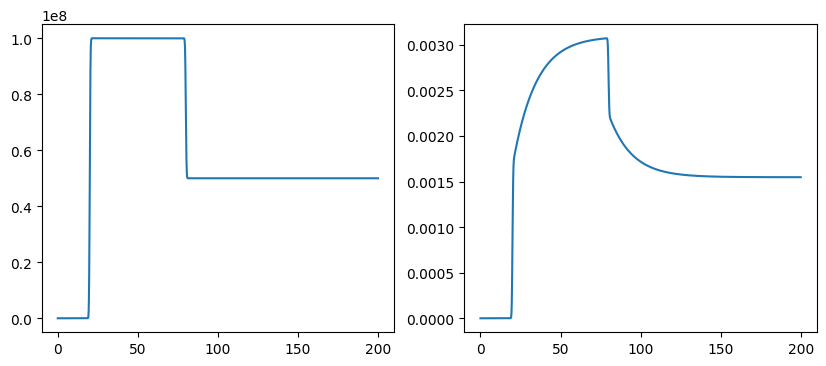

In [8]:
dt_max = stress_ramp_time / 10

strain_vals, stress_vals, t = calc_stress_strain(
    200, dt_max, stress, sls_solid, tmin=0.00000001, n_t=int(1e4)
)

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
axs[0].plot(t, stress_vals)
axs[1].plot(t, strain_vals)

And so we can see a bunch of features of a standard linear solid:

At the onset of the stress ramp, there is an instantaneous elastic response followed by viscous creep that begins to level off. The second stress drop results in an instanenous drop in strain followed by a viscous relaxation to the new equilibration level of strain. 

## An oscillatory stress 

Because we wrote our stress-strain calculator in a general way, we can apply any stress function we want! For example, to apply an oscillatory stress, all we need to do is write a new stress function:

In [9]:
f_Hz = 1 / 100.0
w = 2 * np.pi * f_Hz
stress_amp = 100 * 1e6


def stress(t):
    return np.sin(t * w) * stress_amp

and now we apply our new stress to the same SLS solid. 

We'll set a different `dt_max` based on the applied frequency to ensure that we capture the curvature of the stress function. 

In [10]:
dt_max = 1 / f_Hz / 50
strain_vals, stress_vals, t = calc_stress_strain(
    400, dt_max, stress, sls_solid, tmin=0.00000001, n_t=int(1e4)
)

plotting up our stress and strain curves:

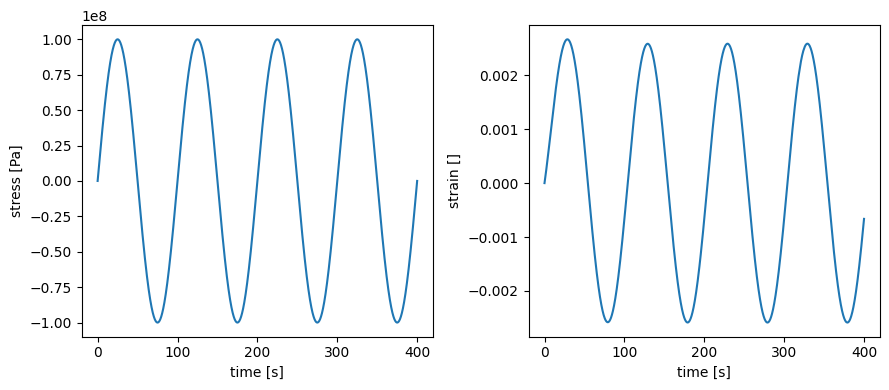

In [11]:
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
axs[0].plot(t, stress_vals)
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("stress [Pa]")
axs[1].plot(t, strain_vals)
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("strain []")
plt.tight_layout()

Let's normalize our stress and strain curves and re-plot:

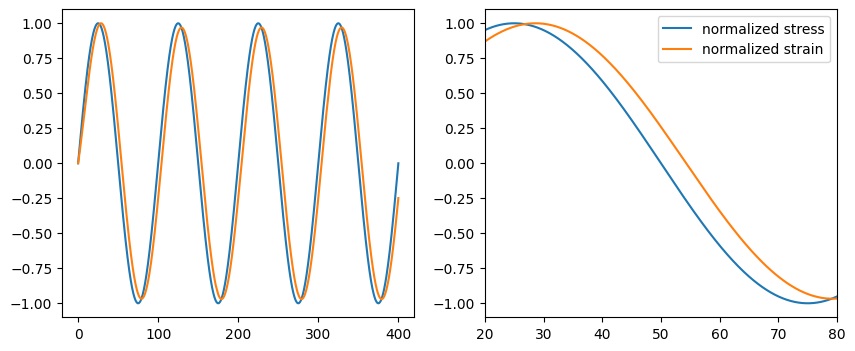

In [12]:
n_strain = strain_vals / strain_vals[t > 20].max()
n_stress = stress_vals / stress_vals.max()

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
axs[0].plot(t, n_stress, label="normalized stress")
axs[0].plot(t, n_strain, label="normalized strain")

axs[1].plot(t, n_stress, label="normalized stress")
axs[1].plot(t, n_strain, label="normalized strain")

axs[1].set_xlim(20, 80)
axs[1].legend()

From this, we see our strain curves lags behind the applied stress! 

The phase lag here is proportional to the attenuation. In the next notebook, we use the `pyleoclim` package to actually calculate this phaselag. 